# ROW Algorithm for Continual Learning
This notebook implements the ROW (Replay, OOD, WP) algorithm to handle continual learning tasks. The objective is to train a model that can incrementally learn new tasks while minimizing catastrophic forgetting.


In [1]:
# Import necessary libraries
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random


In [2]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_data_cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data_cifar10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Load CIFAR-100 dataset
train_data_cifar100 = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_data_cifar100 = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# DataLoaders
train_loader_cifar10 = torch.utils.data.DataLoader(train_data_cifar10, batch_size=64, shuffle=True)
test_loader_cifar10 = torch.utils.data.DataLoader(test_data_cifar10, batch_size=64, shuffle=False)

train_loader_cifar100 = torch.utils.data.DataLoader(train_data_cifar100, batch_size=64, shuffle=True)
test_loader_cifar100 = torch.utils.data.DataLoader(test_data_cifar100, batch_size=64, shuffle=False)


100%|██████████| 170498071/170498071 [00:04<00:00, 34379560.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


100%|██████████| 169001437/169001437 [00:03<00:00, 48874996.08it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


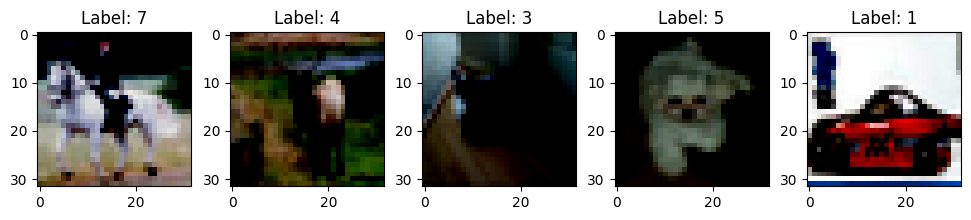

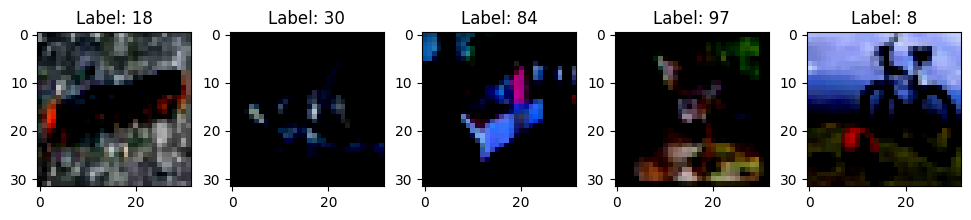

In [3]:
# Display sample images from CIFAR-10
def show_sample_images(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)  # Corrected line
    fig, ax = plt.subplots(1, 5, figsize=(12, 2))
    for i in range(5):
        ax[i].imshow(np.transpose(images[i], (1, 2, 0)))
        ax[i].set_title(f"Label: {labels[i].item()}")
    plt.show()

# Show CIFAR-10 samples
show_sample_images(train_loader_cifar10)

# Show CIFAR-100 samples
show_sample_images(train_loader_cifar100)


In [4]:
import torch.nn as nn
import torchvision.models as models

# Define Feature Extractor using ResNet18 with new 'weights' argument
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)  # Update here
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Remove last FC layer

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)  # Flatten output


In [5]:
# Define OOD and WP heads
class OODHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(OODHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

class WPHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(WPHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)


In [6]:
class ReplayBuffer:
    def __init__(self, capacity=200):
        self.capacity = capacity
        self.buffer = []

    def add(self, data):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)  # Remove the oldest data if buffer is full
        self.buffer.append(data)

    def sample(self, batch_size):
        if len(self.buffer) < batch_size:
            return None  # Not enough data in the buffer
        return random.sample(self.buffer, batch_size)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score

# Define training loop with replay buffer usage and logging metrics
def train_model_with_logging(feature_extractor, ood_head, wp_head, train_loader, replay_buffer, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(feature_extractor.parameters()) + list(ood_head.parameters()) + list(wp_head.parameters()), lr=0.001)
    
    epoch_logs = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        total = 0
        correct_wp = 0
        correct_ood = 0
        all_labels = []
        all_predictions_wp = []
        all_predictions_ood = []
        
        for inputs, labels in train_loader:
            # Forward pass through feature extractor
            features = feature_extractor(inputs)
            
            # OOD and WP outputs
            ood_outputs = ood_head(features)
            wp_outputs = wp_head(features)
            
            # Compute losses
            loss_ood = criterion(ood_outputs, labels)
            loss_wp = criterion(wp_outputs, labels)
            loss = loss_ood + loss_wp
            
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate accuracy for WP and OOD
            _, predicted_wp = torch.max(wp_outputs.data, 1)
            _, predicted_ood = torch.max(ood_outputs.data, 1)
            
            total += labels.size(0)
            correct_wp += (predicted_wp == labels).sum().item()
            correct_ood += (predicted_ood == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions_wp.extend(predicted_wp.cpu().numpy())
            all_predictions_ood.extend(predicted_ood.cpu().numpy())
            
            # Add current batch to replay buffer
            replay_buffer.add((features.detach(), labels.detach()))  # Store features and labels in the buffer

        # Replay training every 2 epochs
        if epoch % 2 == 0:
            replay_data = replay_buffer.sample(32)
            if replay_data is not None:
                replay_features, replay_labels = zip(*replay_data)  # Unpack the replay data
                replay_features = torch.cat(replay_features)
                replay_labels = torch.cat(replay_labels)
                
                # Forward pass on replayed data
                replay_ood_outputs = ood_head(replay_features)
                replay_wp_outputs = wp_head(replay_features)
                
                # Compute replay loss
                loss_replay_ood = criterion(replay_ood_outputs, replay_labels)
                loss_replay_wp = criterion(replay_wp_outputs, replay_labels)
                
                # Optimize using replayed data
                optimizer.zero_grad()
                loss_replay = loss_replay_ood + loss_replay_wp
                loss_replay.backward()
                optimizer.step()
                
                print(f"Training on replay data for epoch {epoch}.")
            else:
                print(f"Not enough data in replay buffer at epoch {epoch}.")

        # Compute accuracy and other metrics
        wp_accuracy = 100 * correct_wp / total
        ood_accuracy = 100 * correct_ood / total
        precision_wp = precision_score(all_labels, all_predictions_wp, average='weighted')
        recall_wp = recall_score(all_labels, all_predictions_wp, average='weighted')
        f1_wp = f1_score(all_labels, all_predictions_wp, average='weighted')
        precision_ood = precision_score(all_labels, all_predictions_ood, average='weighted')
        recall_ood = recall_score(all_labels, all_predictions_ood, average='weighted')
        f1_ood = f1_score(all_labels, all_predictions_ood, average='weighted')

        # Log the metrics for each epoch
        epoch_logs.append({
            'epoch': epoch + 1,
            'loss': running_loss / len(train_loader),
            'wp_accuracy': wp_accuracy,
            'ood_accuracy': ood_accuracy,
            'precision_wp': precision_wp,
            'recall_wp': recall_wp,
            'f1_wp': f1_wp,
            'precision_ood': precision_ood,
            'recall_ood': recall_ood,
            'f1_ood': f1_ood
        })

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, WP Accuracy: {wp_accuracy:.2f}%, OOD Accuracy: {ood_accuracy:.2f}%")
    
    return epoch_logs



In [8]:
# Evaluate model and log metrics
def evaluate_model_with_logging(feature_extractor, wp_head, ood_head, test_loader):
    feature_extractor.eval()
    wp_head.eval()
    ood_head.eval()
    
    correct_wp = 0
    total = 0
    correct_ood = 0
    all_labels = []
    all_predictions_wp = []
    all_predictions_ood = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            features = feature_extractor(inputs)
            wp_outputs = wp_head(features)
            ood_outputs = ood_head(features)
            
            _, predicted_wp = torch.max(wp_outputs.data, 1)
            _, predicted_ood = torch.max(ood_outputs.data, 1)
            
            total += labels.size(0)
            correct_wp += (predicted_wp == labels).sum().item()
            correct_ood += (predicted_ood == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions_wp.extend(predicted_wp.cpu().numpy())
            all_predictions_ood.extend(predicted_ood.cpu().numpy())
    
    wp_accuracy = 100 * correct_wp / total
    ood_accuracy = 100 * correct_ood / total
    precision_wp = precision_score(all_labels, all_predictions_wp, average='weighted')
    recall_wp = recall_score(all_labels, all_predictions_wp, average='weighted')
    f1_wp = f1_score(all_labels, all_predictions_wp, average='weighted')
    precision_ood = precision_score(all_labels, all_predictions_ood, average='weighted')
    recall_ood = recall_score(all_labels, all_predictions_ood, average='weighted')
    f1_ood = f1_score(all_labels, all_predictions_ood, average='weighted')

    print(f"WP Accuracy: {wp_accuracy:.2f}%, OOD Accuracy: {ood_accuracy:.2f}%")
    print(f"WP Precision: {precision_wp:.2f}, WP Recall: {recall_wp:.2f}, WP F1: {f1_wp:.2f}")
    print(f"OOD Precision: {precision_ood:.2f}, OOD Recall: {recall_ood:.2f}, OOD F1: {f1_ood:.2f}")

    return {
        'wp_accuracy': wp_accuracy,
        'ood_accuracy': ood_accuracy,
        'precision_wp': precision_wp,
        'recall_wp': recall_wp,
        'f1_wp': f1_wp,
        'precision_ood': precision_ood,
        'recall_ood': recall_ood,
        'f1_ood': f1_ood
    }


In [9]:
# CIFAR-10 Training and Evaluation
# Initialize components for CIFAR-10
feature_extractor = FeatureExtractor()
ood_head = OODHead(input_dim=512, num_classes=10)  # 10 classes for CIFAR-10
wp_head = WPHead(input_dim=512, num_classes=10)    # 10 classes for CIFAR-10

replay_buffer = ReplayBuffer(capacity=200)

# Train the model for CIFAR-10
train_logs_cifar10 = train_model_with_logging(feature_extractor, ood_head, wp_head, train_loader_cifar10, replay_buffer, num_epochs=15)

# Evaluate the model on CIFAR-10
eval_logs_cifar10 = evaluate_model_with_logging(feature_extractor, wp_head, ood_head, test_loader_cifar10)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


Training on replay data for epoch 0.
Epoch [1/15], Loss: 1491.6636, WP Accuracy: 67.84%, OOD Accuracy: 67.92%
Epoch [2/15], Loss: 1026.3281, WP Accuracy: 78.09%, OOD Accuracy: 78.14%
Training on replay data for epoch 2.
Epoch [3/15], Loss: 811.3803, WP Accuracy: 82.46%, OOD Accuracy: 82.47%
Epoch [4/15], Loss: 643.0448, WP Accuracy: 86.16%, OOD Accuracy: 86.10%
Training on replay data for epoch 4.
Epoch [5/15], Loss: 536.8132, WP Accuracy: 88.36%, OOD Accuracy: 88.31%
Epoch [6/15], Loss: 407.2635, WP Accuracy: 91.00%, OOD Accuracy: 90.98%
Training on replay data for epoch 6.
Epoch [7/15], Loss: 321.9808, WP Accuracy: 92.96%, OOD Accuracy: 92.95%
Epoch [8/15], Loss: 269.2066, WP Accuracy: 94.12%, OOD Accuracy: 94.10%
Training on replay data for epoch 8.
Epoch [9/15], Loss: 215.1922, WP Accuracy: 95.31%, OOD Accuracy: 95.29%
Epoch [10/15], Loss: 203.9046, WP Accuracy: 95.53%, OOD Accuracy: 95.52%
Training on replay data for epoch 10.
Epoch [11/15], Loss: 155.5548, WP Accuracy: 96.72%, OO

In [10]:
# CIFAR-100 Training and Evaluation
# Update the heads for CIFAR-100 (100 classes)
ood_head = OODHead(input_dim=512, num_classes=100)  # 100 classes for CIFAR-100
wp_head = WPHead(input_dim=512, num_classes=100)    # 100 classes for CIFAR-100

# Train the model for CIFAR-100
train_logs_cifar100 = train_model_with_logging(feature_extractor, ood_head, wp_head, train_loader_cifar100, replay_buffer, num_epochs=15)

# Evaluate the model on CIFAR-100
eval_logs_cifar100 = evaluate_model_with_logging(feature_extractor, wp_head, ood_head, test_loader_cifar100)


Training on replay data for epoch 0.
Epoch [1/15], Loss: 4618.5922, WP Accuracy: 24.52%, OOD Accuracy: 24.53%
Epoch [2/15], Loss: 3353.9974, WP Accuracy: 41.28%, OOD Accuracy: 41.36%
Training on replay data for epoch 2.
Epoch [3/15], Loss: 2687.1933, WP Accuracy: 51.18%, OOD Accuracy: 51.19%
Epoch [4/15], Loss: 2139.1869, WP Accuracy: 59.99%, OOD Accuracy: 59.96%
Training on replay data for epoch 4.
Epoch [5/15], Loss: 1660.4938, WP Accuracy: 67.50%, OOD Accuracy: 67.47%
Epoch [6/15], Loss: 1246.8045, WP Accuracy: 74.88%, OOD Accuracy: 74.96%
Training on replay data for epoch 6.
Epoch [7/15], Loss: 942.6786, WP Accuracy: 80.44%, OOD Accuracy: 80.43%
Epoch [8/15], Loss: 713.3004, WP Accuracy: 85.14%, OOD Accuracy: 85.12%
Training on replay data for epoch 8.
Epoch [9/15], Loss: 578.2430, WP Accuracy: 87.89%, OOD Accuracy: 87.84%
Epoch [10/15], Loss: 509.1499, WP Accuracy: 89.22%, OOD Accuracy: 89.17%
Training on replay data for epoch 10.
Epoch [11/15], Loss: 423.3895, WP Accuracy: 91.02%

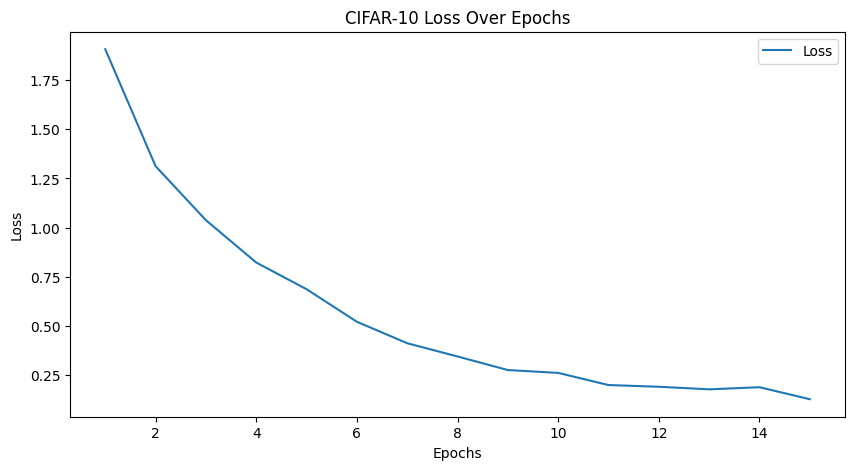

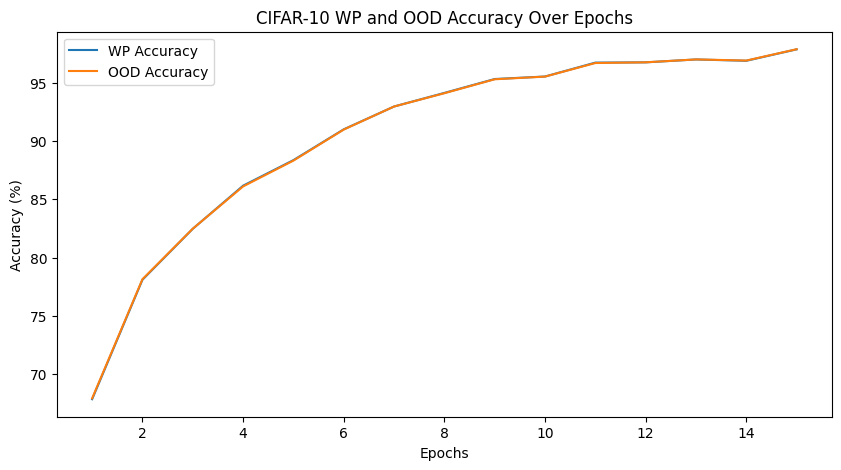

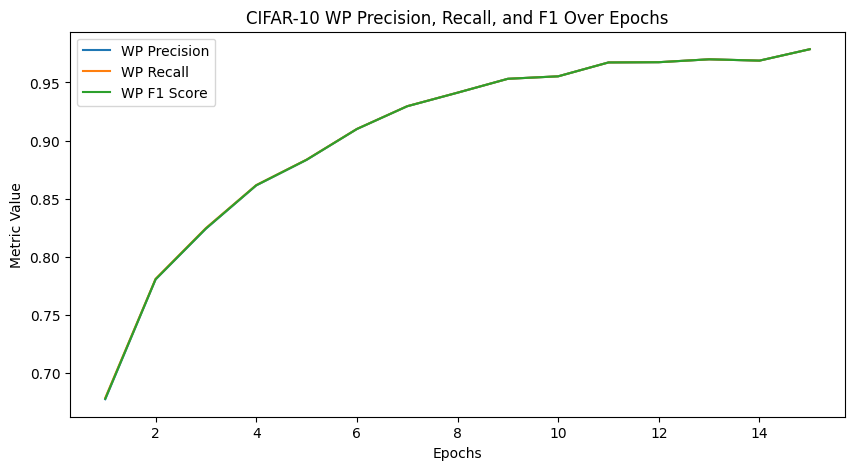

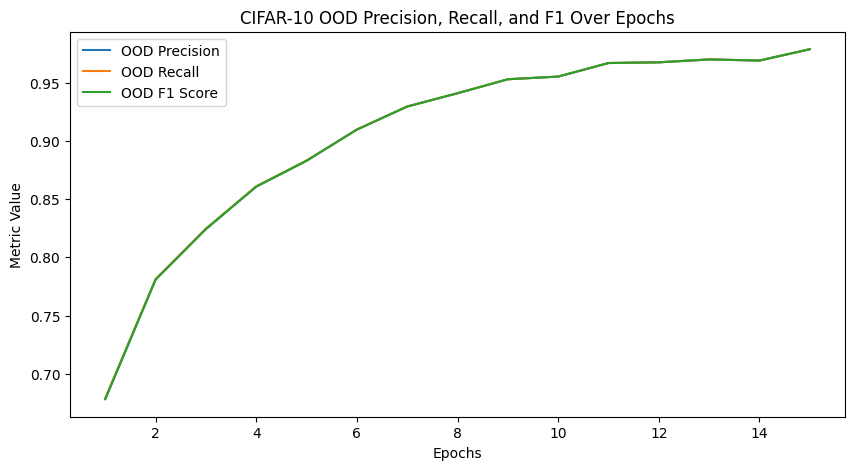

In [11]:
import matplotlib.pyplot as plt

# Assuming 'train_logs_cifar10' contains the logs for CIFAR-10 from the train_model_with_metrics function
epochs = [log['epoch'] for log in train_logs_cifar10]
losses = [log['loss'] for log in train_logs_cifar10]
wp_accuracies = [log['wp_accuracy'] for log in train_logs_cifar10]
ood_accuracies = [log['ood_accuracy'] for log in train_logs_cifar10]
wp_precisions = [log['precision_wp'] for log in train_logs_cifar10]
wp_recalls = [log['recall_wp'] for log in train_logs_cifar10]
wp_f1_scores = [log['f1_wp'] for log in train_logs_cifar10]
ood_precisions = [log['precision_ood'] for log in train_logs_cifar10]
ood_recalls = [log['recall_ood'] for log in train_logs_cifar10]
ood_f1_scores = [log['f1_ood'] for log in train_logs_cifar10]

# Plot Loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CIFAR-10 Loss Over Epochs')
plt.legend()
plt.show()

# Plot WP and OOD Accuracies over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, wp_accuracies, label='WP Accuracy')
plt.plot(epochs, ood_accuracies, label='OOD Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('CIFAR-10 WP and OOD Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot Precision, Recall, and F1 for WP
plt.figure(figsize=(10, 5))
plt.plot(epochs, wp_precisions, label='WP Precision')
plt.plot(epochs, wp_recalls, label='WP Recall')
plt.plot(epochs, wp_f1_scores, label='WP F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('CIFAR-10 WP Precision, Recall, and F1 Over Epochs')
plt.legend()
plt.show()

# Plot Precision, Recall, and F1 for OOD
plt.figure(figsize=(10, 5))
plt.plot(epochs, ood_precisions, label='OOD Precision')
plt.plot(epochs, ood_recalls, label='OOD Recall')
plt.plot(epochs, ood_f1_scores, label='OOD F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('CIFAR-10 OOD Precision, Recall, and F1 Over Epochs')
plt.legend()
plt.show()


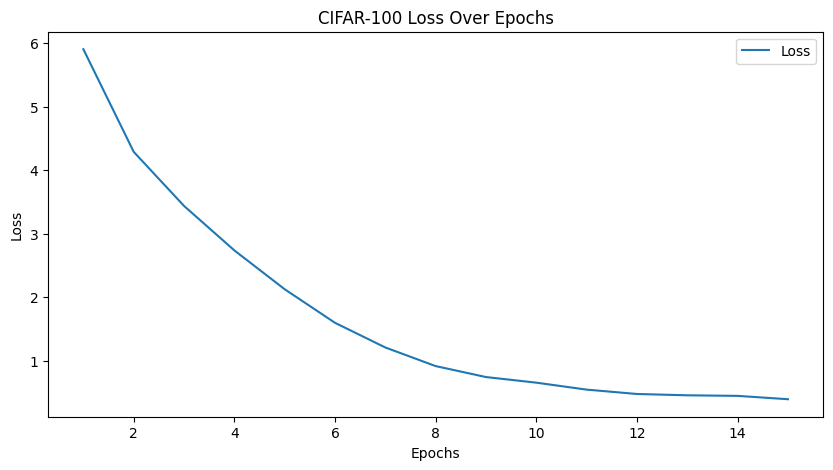

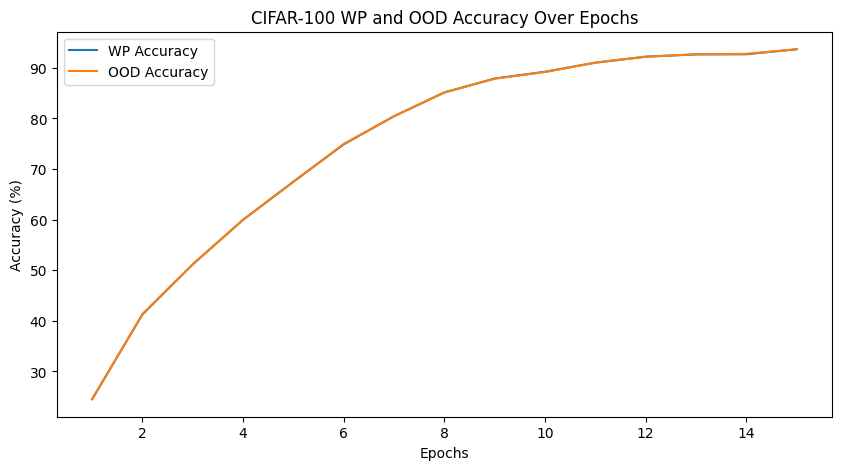

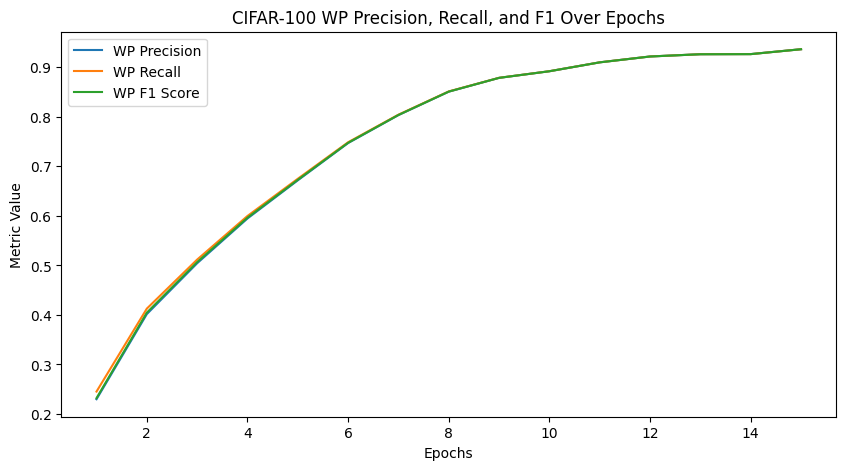

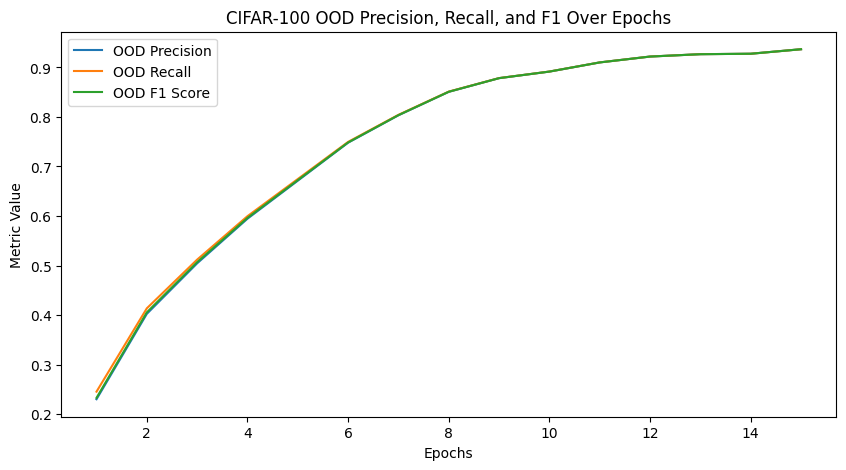

In [12]:
# Assuming 'train_logs_cifar100' contains the logs for CIFAR-100 from the train_model_with_metrics function
epochs_cifar100 = [log['epoch'] for log in train_logs_cifar100]
losses_cifar100 = [log['loss'] for log in train_logs_cifar100]
wp_accuracies_cifar100 = [log['wp_accuracy'] for log in train_logs_cifar100]
ood_accuracies_cifar100 = [log['ood_accuracy'] for log in train_logs_cifar100]
wp_precisions_cifar100 = [log['precision_wp'] for log in train_logs_cifar100]
wp_recalls_cifar100 = [log['recall_wp'] for log in train_logs_cifar100]
wp_f1_scores_cifar100 = [log['f1_wp'] for log in train_logs_cifar100]
ood_precisions_cifar100 = [log['precision_ood'] for log in train_logs_cifar100]
ood_recalls_cifar100 = [log['recall_ood'] for log in train_logs_cifar100]
ood_f1_scores_cifar100 = [log['f1_ood'] for log in train_logs_cifar100]

# Plot Loss over epochs for CIFAR-100
plt.figure(figsize=(10, 5))
plt.plot(epochs_cifar100, losses_cifar100, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CIFAR-100 Loss Over Epochs')
plt.legend()
plt.show()

# Plot WP and OOD Accuracies over epochs for CIFAR-100
plt.figure(figsize=(10, 5))
plt.plot(epochs_cifar100, wp_accuracies_cifar100, label='WP Accuracy')
plt.plot(epochs_cifar100, ood_accuracies_cifar100, label='OOD Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('CIFAR-100 WP and OOD Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot Precision, Recall, and F1 for WP in CIFAR-100
plt.figure(figsize=(10, 5))
plt.plot(epochs_cifar100, wp_precisions_cifar100, label='WP Precision')
plt.plot(epochs_cifar100, wp_recalls_cifar100, label='WP Recall')
plt.plot(epochs_cifar100, wp_f1_scores_cifar100, label='WP F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('CIFAR-100 WP Precision, Recall, and F1 Over Epochs')
plt.legend()
plt.show()

# Plot Precision, Recall, and F1 for OOD in CIFAR-100
plt.figure(figsize=(10, 5))
plt.plot(epochs_cifar100, ood_precisions_cifar100, label='OOD Precision')
plt.plot(epochs_cifar100, ood_recalls_cifar100, label='OOD Recall')
plt.plot(epochs_cifar100, ood_f1_scores_cifar100, label='OOD F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('CIFAR-100 OOD Precision, Recall, and F1 Over Epochs')
plt.legend()
plt.show()


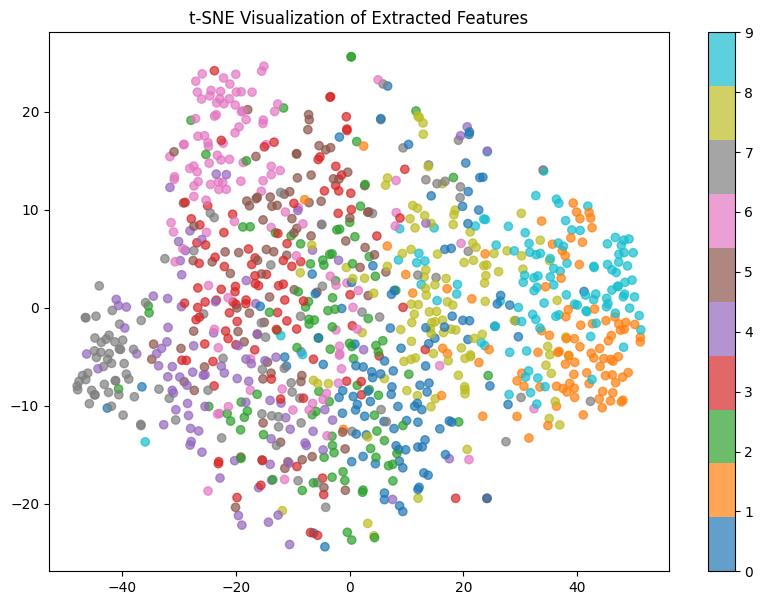

In [19]:
from sklearn.manifold import TSNE
import numpy as np

def visualize_features(feature_extractor, test_loader, n_samples=1000):
    features = []
    labels = []

    with torch.no_grad():
        for i, (inputs, labels_batch) in enumerate(test_loader):
            if i * len(inputs) > n_samples:
                break
            features_batch = feature_extractor(inputs).cpu().numpy()
            features.append(features_batch)
            labels.append(labels_batch.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Use t-SNE for feature visualization
    tsne = TSNE(n_components=2)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(10, 7))
    plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar()
    plt.title('t-SNE Visualization of Extracted Features')
    plt.show()

# CIFAR-10
visualize_features(feature_extractor, test_loader_cifar10)
